## Predicting Service Failures

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scikitplot as skplt
import scipy
%matplotlib inline
from scipy.stats import linregress
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from statistics import mean
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy.fftpack
from scipy.signal import find_peaks
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

### Get the Service Failures Data

In [2]:
ls

1533148882_failures.csv   Service_Disruption.ipynb  Untitled1.ipynb
HackDay4.ipynb            Untitled.ipynb            sol/


In [3]:
df = pd.read_csv("1533148882_failures.csv")

### Show Basic info about Devices

In [4]:
df.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 12 columns):
date          124494 non-null object
device        124494 non-null object
failure       124494 non-null int64
attribute1    124494 non-null int64
attribute2    124494 non-null int64
attribute3    124494 non-null int64
attribute4    124494 non-null int64
attribute5    124494 non-null int64
attribute6    124494 non-null int64
attribute7    124494 non-null int64
attribute8    124494 non-null int64
attribute9    124494 non-null int64
dtypes: int64(10), object(2)
memory usage: 11.4+ MB


In [6]:
abs(df.corr()['failure'].sort_values(ascending=False))

failure       1.000000
attribute8    0.119055
attribute7    0.119055
attribute4    0.067398
attribute2    0.052902
attribute5    0.002270
attribute1    0.001984
attribute9    0.001622
attribute6    0.000550
attribute3    0.000948
Name: failure, dtype: float64

In [7]:
df.describe()

,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
count,124494.000000,1.244940e+05,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000
mean,0.000851,1.223868e+08,159.484762,9.940455,1.741120,14.222693,260172.858025,0.292528,0.292528,12.451524
std,0.029167,7.045960e+07,2179.657730,185.747321,22.908507,15.943021,99151.009852,7.436924,7.436924,191.425623
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000
25%,0.000000,6.127675e+07,0.000000,0.000000,0.000000,8.000000,221452.000000,0.000000,0.000000,0.000000
50%,0.000000,1.227957e+08,0.000000,0.000000,0.000000,10.000000,249799.500000,0.000000,0.000000,0.000000
75%,0.000000,1.833084e+08,0.000000,0.000000,0.000000,12.000000,310266.000000,0.000000,0.000000,0.000000
max,1.000000,2.441405e+08,64968.000000,24929.000000,1666.000000,98.000000,689161.000000,832.000000,832.000000,18701.000000


#### There's a huge disproportion between failures and non failures- .08% failure/nonfailure

In [8]:
df[df['failure'] == 1].shape, df[df['failure'] == 0].shape

((106, 12), (124388, 12))

#### Attribute8 appears be a copy of Attribute7

In [9]:
df.drop(['attribute8'], axis=1, inplace=True)

#### Attribute correspondence to Failure

In [10]:
abs(df.corr()['failure'].sort_values(ascending=False))

failure       1.000000
attribute7    0.119055
attribute4    0.067398
attribute2    0.052902
attribute5    0.002270
attribute1    0.001984
attribute9    0.001622
attribute6    0.000550
attribute3    0.000948
Name: failure, dtype: float64

#### Date/Time Parsing

In [11]:
df['date'] = pd.to_datetime(df['date'])

In [12]:
df.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,3


In [13]:
df['date'].min()

Timestamp('2015-01-01 00:00:00')

#### Duration_on shows how long the device operated until failing

In [14]:
df['Duration_On'] = df['date'] - df['date'].min()
df['Duration_On'] = df['Duration_On'].replace(['days', ' '], '').astype('int')

#### Extract Month, Day, and Year from the date

In [15]:
df['month']=df['date'].dt.month
df['day']=df.date.dt.weekday
df['day'].replace(0,7,inplace=True)
df['year']=df.date.dt.year

In [16]:
df.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9,Duration_On,month,day,year
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,7,0,1,3,2015
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0,1,3,2015
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0,1,3,2015
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0,1,3,2015
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,3,0,1,3,2015


#### This is only for one year.  So year is not a helpful attribute.

In [17]:
df['year'].unique()

array([2015])

#### Group according to the last device to extract the last state of devices

In [18]:
df = df.groupby('device').last()
df.reset_index(inplace = True)

#### Groupby increased the failure/non failure ratio dramatically to ~10%

In [19]:
df[df['failure'] == 1].shape, df[df['failure'] == 0].shape

((101, 15), (1067, 15))

#### Plots overlayed histograms of Months for failure and non failure cases

In [20]:
def gettimeplot(df_in):
    df_failure = df[df['failure']==1]
    df_nonfailure = df[df['failure']==0]
    
    plt.hist(df_nonfailure['month'], bins=13)
    plt.hist(df_failure['month'], bins=13)
    plt.yscale('log')
    plt.xlabel('Month')
    plt.ylabel('Counts')
    plt.legend(['NonFailure', 'Failure'], loc='best')
    plt.title("Failures/NonFailures vs Month")

#### There's a little bit of seasonality in failures.  The beginning of the year has order of magnitude greater failures than months later in the year.

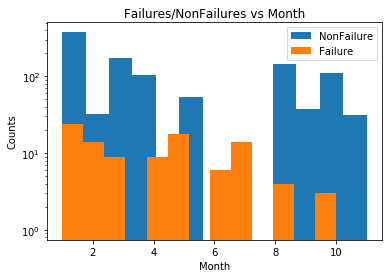

In [21]:
gettimeplot(df)

#### Histograms of all the Attributes - Many of the Attributes here are clearly skewed/ have outliers.  

#### Attribute5

In [22]:
def cutofflesser(df_in, elem, cutoff):
    
    df_out = df_in[df_in[elem]>cutoff]
    NewTrainingdatasize = df_out.shape[0]
    
    return df_out, NewTrainingdatasize

In [23]:
def cutoffgreater(df_in, elem, cutoff):
    
    df_out = df_in[df_in[elem]<cutoff]
    NewTrainingdatasize = df_out.shape[0]
    
    return df_out, NewTrainingdatasize

In [24]:
def plotattributes(dfin):
    
    dfin = dfin.select_dtypes(exclude=['object'])
    
    for elem in dfin:
        plt.hist(dfin[elem], bins=200)
        plt.yscale('log')

        plt.ylabel('counts', fontsize=13)
        plt.xlabel(str(elem), fontsize=13)
        plt.show()

In [25]:
def GenerateClassPlot(dfin, elem_x, elem_y, model = RandomForestClassifier()):
    
    #model = RandomForestClassifier()
    model.fit(dfin[elem_x].to_frame(), dfin[elem_y])
    x_pred = pd.DataFrame(np.linspace(0, dfin[elem_x].max(), dfin[elem_y].shape[0]))
    y_pred = pd.DataFrame(model.predict(x_pred))
    y_true = dfin[elem_y].to_frame()
    
    
    accuracy = accuracy_score(y_true, y_pred)
    
    #print(x_pred.shape, y_pred.shape, y_true.shape, df[elem_x].to_frame().shape)
    
    fig1 = plt.figure(figsize = (20,5))
    fig1.suptitle(str(elem_x), fontsize=16)
    a = fig1.add_subplot(131)
    a.plot(x_pred, y_pred, 'r')
    a.scatter(dfin[elem_x].to_frame(), y_true)
    a.set_ylabel('Probability of Failure', fontsize=13)
    a.set_xlabel(str(elem_x), fontsize=13)

    b = fig1.add_subplot(132)
    df_1 = dfin[dfin['failure'] == 1]
    df_0 = dfin[dfin['failure'] == 0]
    
    b.hist(df_1[elem_x], bins=50, color = 'orange', zorder = 10)
    b.hist(df_0[elem_x], bins=100, color = 'darkblue',  zorder = 0)
    b.set_yscale('log')
    b.set_ylabel('counts', fontsize=13)
    b.set_xlabel(str(elem_x), fontsize=13)
    b.legend(['Failure', 'Non-Failure'])
    
    c = fig1.add_subplot(133)
    fpr, tpr, _ = roc_curve(y_true,  y_pred)
    auc = roc_auc_score(y_true, y_pred)
    c.plot(fpr,tpr,label=str(elem_x)+"\nAUC: "+str(auc)[:6] + "\nAccuracy: "+str(accuracy)[:6])
    c.set_ylabel('True Positive Rate', fontsize=13)
    c.set_xlabel('False Positive Rate', fontsize=13)
    c.legend(loc=4)

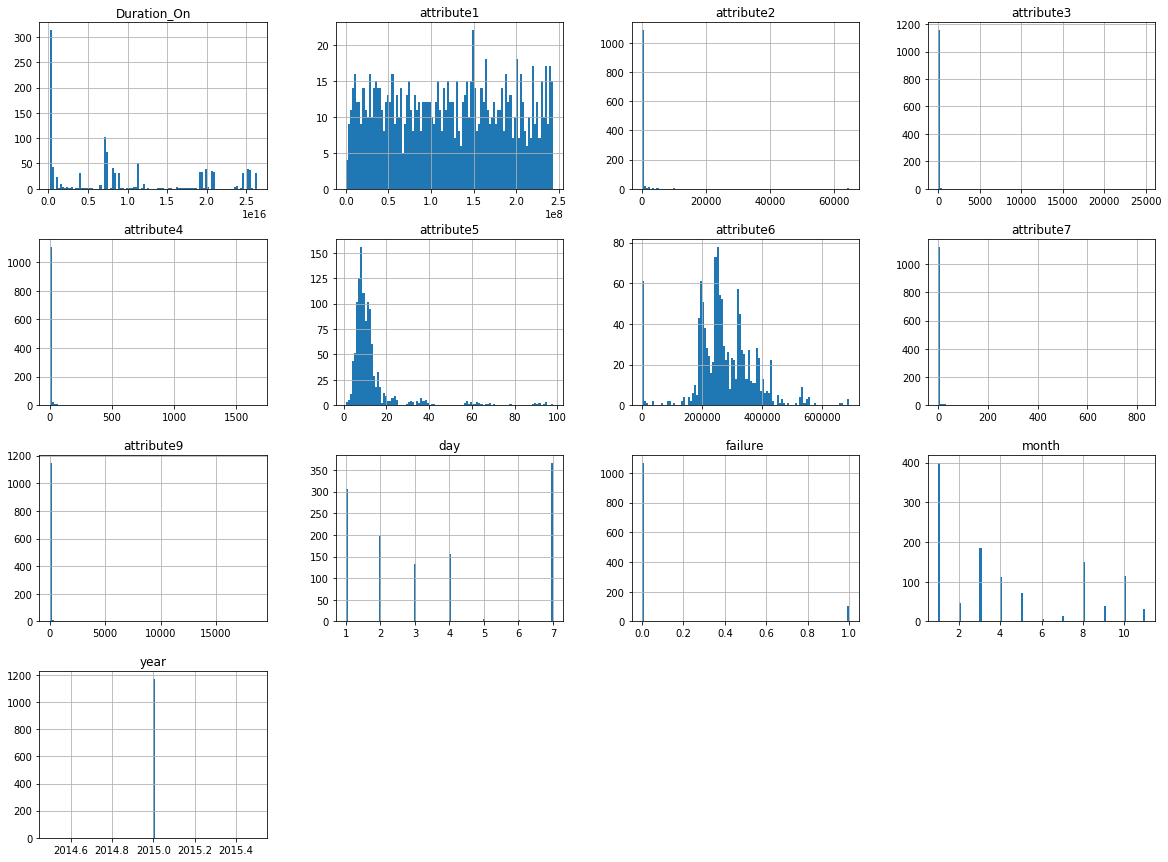

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
df.hist(bins=100, figsize=(20,15))
plt.show()

### Attribute2 

#### There aren't any Non-Failure outliers to throw away

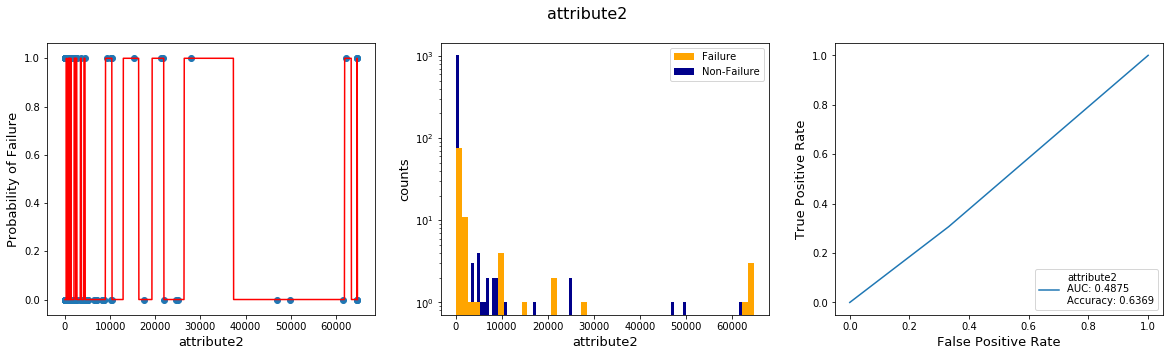

In [27]:
GenerateClassPlot(df, 'attribute2', 'failure')

### Attribute3 

#### There are a few non failure that could be removed

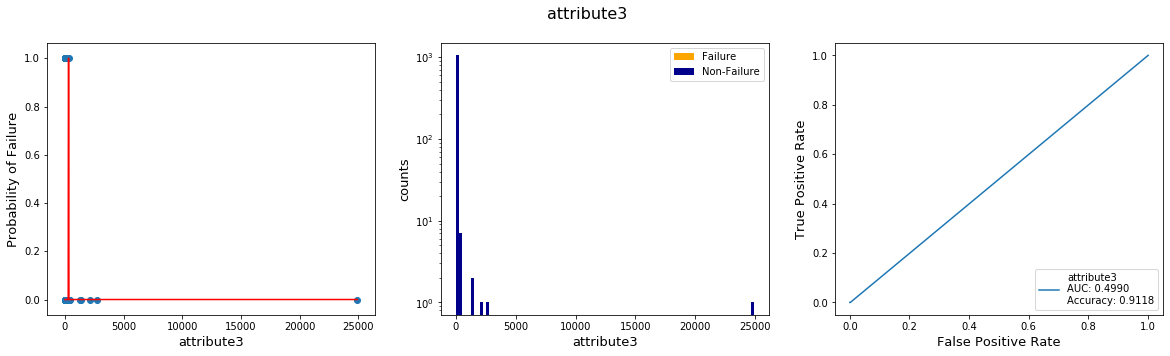

In [28]:
GenerateClassPlot(df, 'attribute3', 'failure')

#### The largest attribute3 value with a failure is 318.  So, I'll cut off all the non-failure passed this value.

In [29]:
df[df['failure'] == 1]['attribute3'].max()

318

In [30]:
df[df['failure'] == 1].shape, df[df['failure'] == 0].shape

((101, 15), (1067, 15))

#### Removed all entries with attribute3 > 318.  Reduced Failure/NonFailure ratio slightly.

In [31]:
df, trainingsize = cutoffgreater(df, 'attribute3', 319)
df[df['failure'] == 1].shape, df[df['failure'] == 0].shape

((101, 15), (1058, 15))

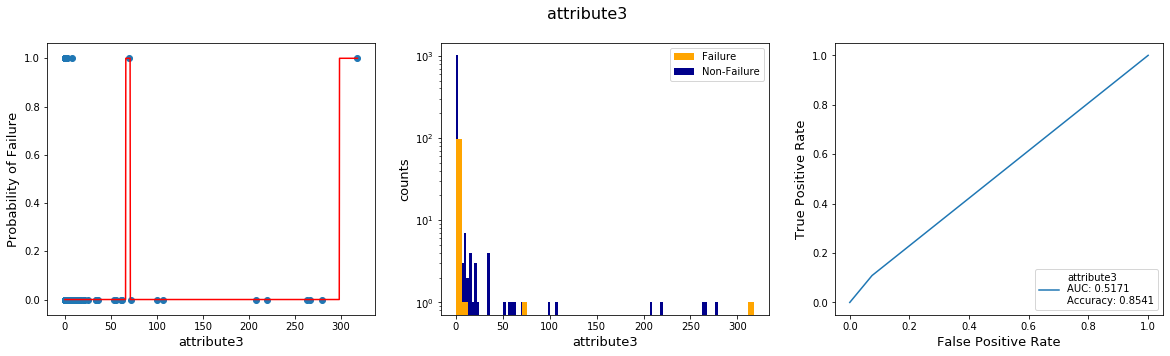

In [32]:
GenerateClassPlot(df, 'attribute3', 'failure')

### Attribute4

#### Can't throw anything away here.

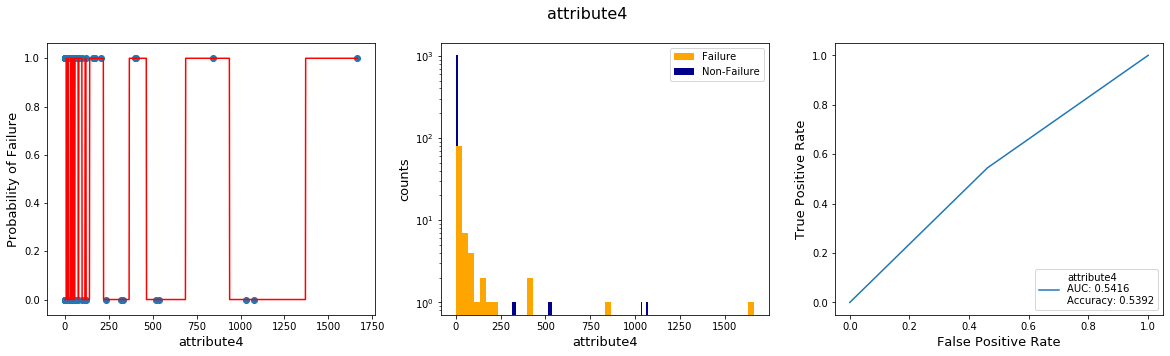

In [33]:
GenerateClassPlot(df, 'attribute4', 'failure')

### Attribute5 

#### Data is skewed and has outliers to remove

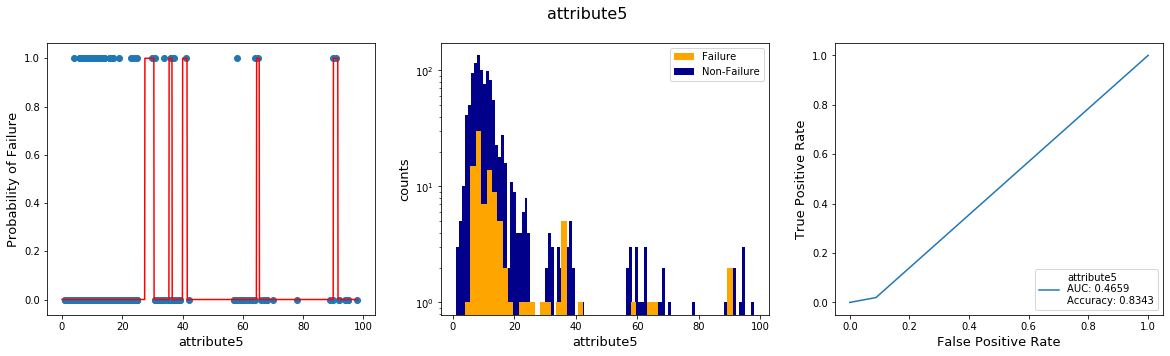

In [34]:
GenerateClassPlot(df, 'attribute5', 'failure')

In [35]:
df[df['failure'] == 1]['attribute5'].max(), df[df['failure'] == 1]['attribute5'].min()

(91, 4)

In [36]:
df[df['failure'] == 1].shape, df[df['failure'] == 0].shape

((101, 15), (1058, 15))

#### Remove all entries with attribute5 greater than 92

In [37]:
df, trainingsize = cutoffgreater(df, 'attribute5', 92)
df[df['failure'] == 1].shape, df[df['failure'] == 0].shape

((101, 15), (1051, 15))

#### Remove all entries with attribute5 less than 4

In [38]:
df, trainingsize = cutofflesser(df, 'attribute5', 3)
df[df['failure'] == 1].shape, df[df['failure'] == 0].shape

((101, 15), (1033, 15))

#### Applying log helps to resolve the large skew

In [39]:
df['attribute5'] = df['attribute5'].apply(lambda x: np.log(x+1))

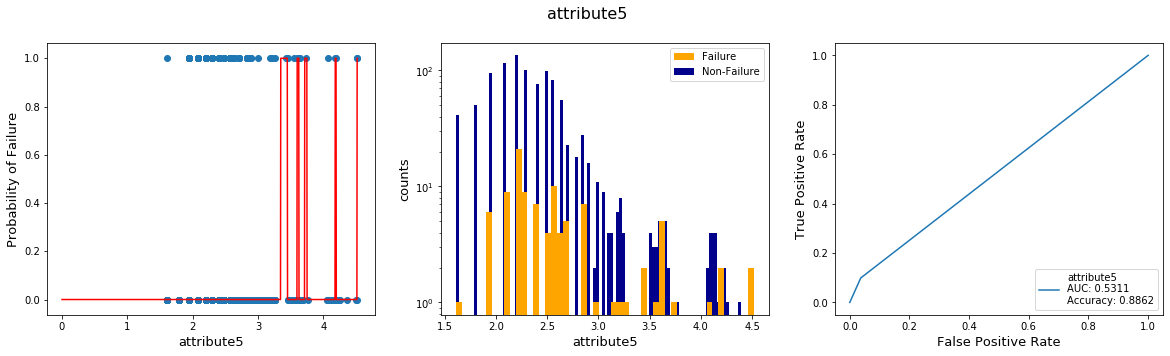

In [40]:
GenerateClassPlot(df, 'attribute5', 'failure')

### Attribute6

#### Data has some outliers that can be removed.

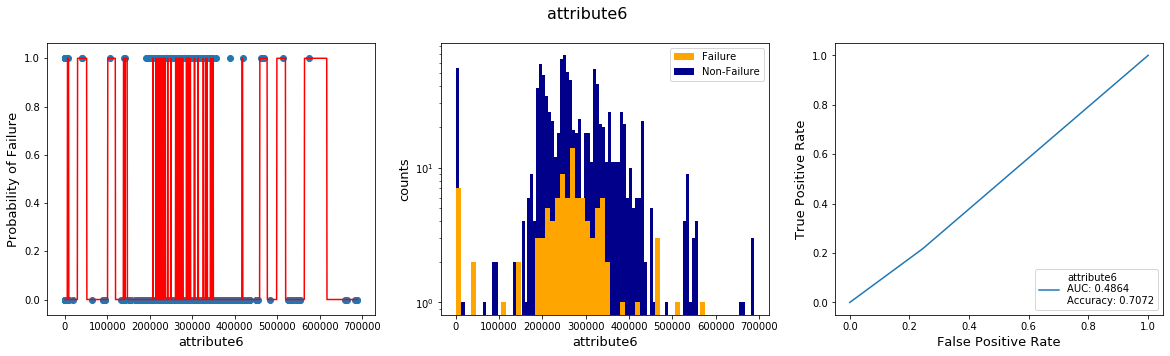

In [41]:
GenerateClassPlot(df, 'attribute6', 'failure')

In [42]:
df[df['failure'] == 1]['attribute6'].max()

574599

In [43]:
df[df['failure'] == 1].shape, df[df['failure'] == 0].shape

((101, 15), (1033, 15))

#### Remove all entries with Attribute6 larger than 574599

In [44]:
df, trainingsize = cutoffgreater(df, 'attribute6', 574600)
df[df['failure'] == 1].shape, df[df['failure'] == 0].shape

((101, 15), (1028, 15))

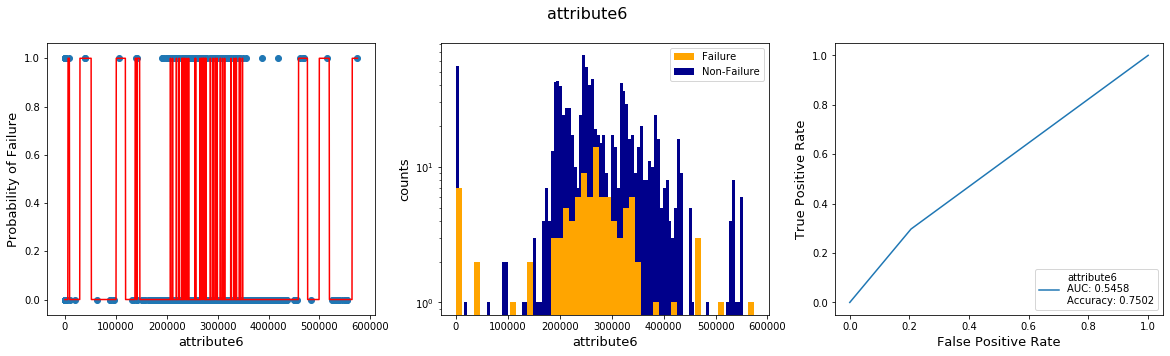

In [45]:
GenerateClassPlot(df, 'attribute6', 'failure')

### Attribute7

#### Nothing to remove here

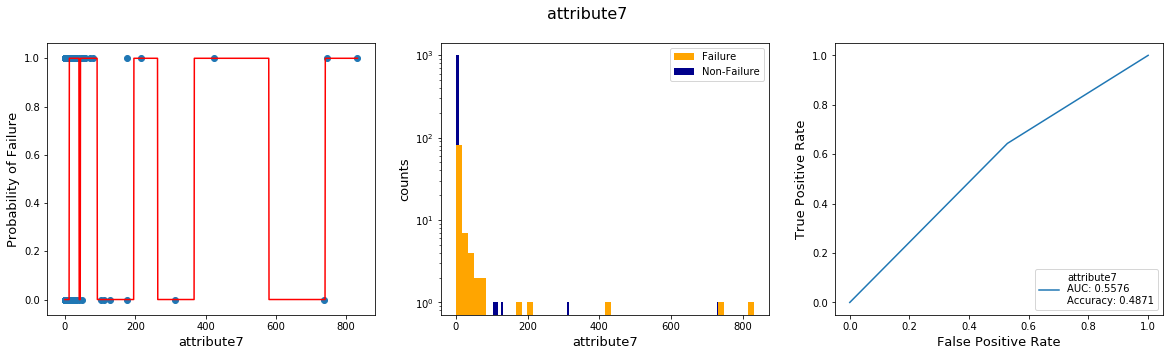

In [46]:
GenerateClassPlot(df, 'attribute7', 'failure')

### Attribute9

#### Some outliers that can be removed here.

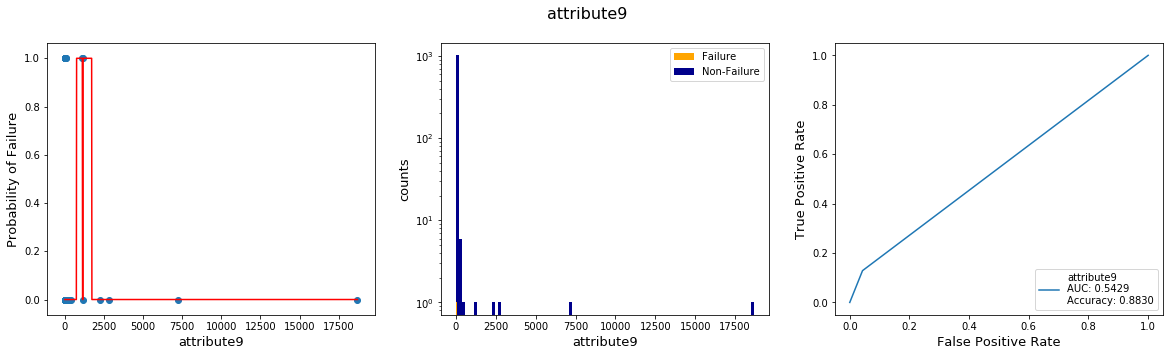

In [47]:
GenerateClassPlot(df, 'attribute9', 'failure')

In [48]:
df[df['failure'] == 1]['attribute9'].max()

1165

In [49]:
df[df['failure'] == 1].shape, df[df['failure'] == 0].shape

((101, 15), (1028, 15))

In [50]:
df, trainingsize = cutoffgreater(df, 'attribute9', 1166)
df[df['failure'] == 1].shape, df[df['failure'] == 0].shape

((101, 15), (1024, 15))

In [51]:
#df['attribute9'] = df['attribute9'].apply(lambda x: np.log(x+1))

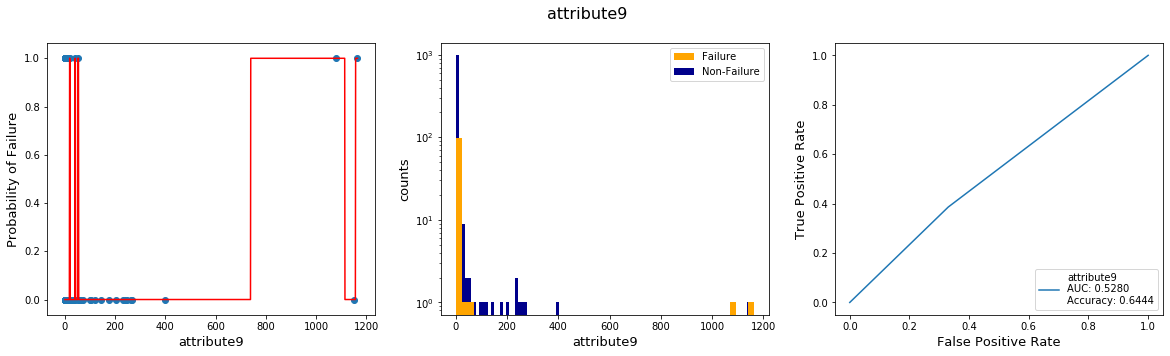

In [52]:
GenerateClassPlot(df, 'attribute9', 'failure')

#### Data has no nulls

In [53]:
df.isnull().sum()

device         0
date           0
failure        0
attribute1     0
attribute2     0
attribute3     0
attribute4     0
attribute5     0
attribute6     0
attribute7     0
attribute9     0
Duration_On    0
month          0
day            0
year           0
dtype: int64

#### Device and date need to be dropped.  Also year needs to be dropped since there is only one unique value.

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1125 entries, 0 to 1167
Data columns (total 15 columns):
device         1125 non-null object
date           1125 non-null datetime64[ns]
failure        1125 non-null int64
attribute1     1125 non-null int64
attribute2     1125 non-null int64
attribute3     1125 non-null int64
attribute4     1125 non-null int64
attribute5     1125 non-null float64
attribute6     1125 non-null int64
attribute7     1125 non-null int64
attribute9     1125 non-null int64
Duration_On    1125 non-null int64
month          1125 non-null int64
day            1125 non-null int64
year           1125 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(12), object(1)
memory usage: 140.6+ KB


In [55]:
df.drop(['device', 'date', 'year'], axis=1, inplace=True)

#### Correspondence to Failure

In [56]:
abs(df.corr()['failure'].sort_values(ascending=False))

failure        1.000000
attribute7     0.193481
attribute4     0.175294
attribute2     0.171000
attribute5     0.110998
attribute9     0.087857
attribute3     0.034002
day            0.021469
attribute1     0.019764
Duration_On    0.025863
month          0.034175
attribute6     0.035199
Name: failure, dtype: float64

#### Ratio of Failure to NonFailures decreased from .08% to 10%

In [57]:
df[df['failure'] == 1].shape, df[df['failure'] == 0].shape

((101, 12), (1024, 12))

In [58]:
def GenAUCCurve(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    fpr, tpr, _ = roc_curve(y_true,  y_pred)
    auc = roc_auc_score(y_true, y_pred)
    plt.plot(fpr,tpr)
    plt.legend(["\nAUC: "+str(auc)[:6] + "\nAccuracy: "+str(accuracy)[:6]], loc='best')
    plt.ylabel('True Positive Rate', fontsize=13)
    plt.xlabel('False Positive Rate', fontsize=13)
    plt.show()
    

In [59]:
def OptimalRegression(XData, y):
    
    g = GaussianNB()
    b = BernoulliNB()
    k = KNeighborsClassifier()
    log = LogisticRegression()
    gbc = GradientBoostingClassifier()
    d = DecisionTreeClassifier()
    r = RandomForestClassifier()
    
    algorithms = [g,b,k,log,d,r,gbc]
    names = ['GaussianNB', 'BernoulliNB', 'K Nearest', 'Logistic','Single Tree','Random Forest', 'GradientBoost']

    x_train, x_test, y_train, y_test = train_test_split(XData, y, train_size=0.8, random_state=0)
    
    accuracy = []
    precision = []
    recall = []
    f1 = []
    
    largest_f1 = 0
    bestmodel = 0
        
    for algo in algorithms:
        algo.fit(x_train,y_train)
        y_pred = algo.predict(x_test)
        
        accuracy.append(accuracy_score(y_test, y_pred))
        precision.append(precision_score(y_test, y_pred))
        recall.append(recall_score(y_test, y_pred))
        f1_val = f1_score(y_test, y_pred)
        f1.append(f1_val)
        if(f1_val < .95) and (f1_val > largest_f1):
            largest_f1 = f1_val
            bestmodel = algo
        
    metrics = pd.DataFrame(columns = ['Accuracy', 'Precision', 'Recall', 'F1'], index = names)
    metrics['Accuracy'] = accuracy
    metrics['Precision'] = precision
    metrics['Recall'] = recall
    metrics['F1'] = f1
     
    stats = metrics.sort_values('F1', ascending = False)
    
    bestmodel.fit(x_train,y_train)
    y_pred = algo.predict(x_test)
    
    GenAUCCurve(y_test, y_pred)
    print(largest_f1)
    
    return bestmodel, stats

#### Gradient Boost and K Nearest perform well here.

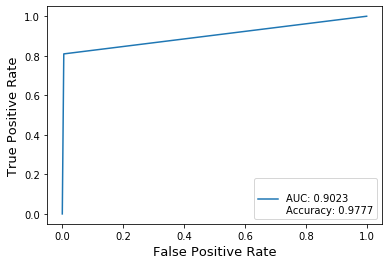

0.8421052631578947


,Accuracy,Precision,Recall,F1
GradientBoost,0.973333,0.941176,0.761905,0.842105
K Nearest,0.968889,0.888889,0.761905,0.820513
Random Forest,0.960000,0.928571,0.619048,0.742857
Single Tree,0.911111,0.529412,0.428571,0.473684
BernoulliNB,0.897778,0.416667,0.238095,0.303030
GaussianNB,0.906667,0.000000,0.000000,0.000000
Logistic,0.906667,0.000000,0.000000,0.000000


In [60]:
best_model, stats = OptimalRegression(df.drop('failure', axis=1), df['failure'])
stats

### Random Under Sampling

In [61]:
count_class_0, count_class_1 = df.failure.value_counts()
df_class_0 = df[df['failure'] == 0]
df_class_1 = df[df['failure'] == 1]

In [62]:
df_class_0_under = df_class_0.sample(count_class_1)
df_under = pd.concat([df_class_0_under, df_class_1], axis=0)

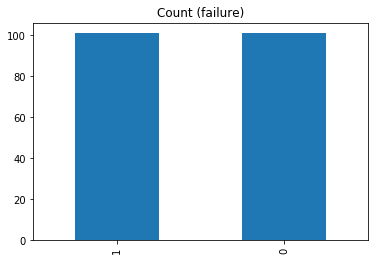

In [63]:
df_under.failure.value_counts().plot(kind='bar', title='Count (failure)');

### Random Over Sampling

In [64]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_over = pd.concat([df_class_0, df_class_1_over], axis=0)

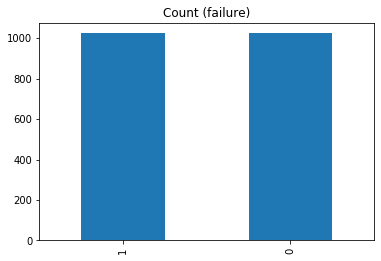

In [65]:
df_over.failure.value_counts().plot(kind='bar', title='Count (failure)');

In [66]:
abs(df_under.corr()['failure']).sort_values(ascending = False)

failure        1.000000
attribute7     0.186018
attribute4     0.178730
attribute2     0.150727
attribute5     0.131745
month          0.114143
Duration_On    0.100227
attribute3     0.065056
attribute9     0.028256
attribute1     0.025440
day            0.016929
attribute6     0.013866
Name: failure, dtype: float64

In [67]:
abs(df_over.corr()['failure']).sort_values(ascending = False)

failure        1.000000
attribute2     0.173294
attribute5     0.169736
attribute7     0.167172
attribute4     0.159025
attribute6     0.096386
attribute9     0.095424
attribute1     0.077481
month          0.043390
day            0.041009
attribute3     0.032684
Duration_On    0.028165
Name: failure, dtype: float64